In [1]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

Using TensorFlow backend.


In [2]:
from SqueezeDetHelpers import get_all_points_from_prediction
from Models.PoolingAndFire import create_loss_function
from PreProcess import get_anchors, load_data_with_anchors, get_left_hand, get_right_hand

In [3]:
MODEL_FILE = r"results/index1_detect_longrun.h5py"
ANNOTATIONS_PATH = os.path.expanduser("~/datasets/RHD/RHD_published_v2/training/annotations")
RHD_ANNOTATIONS_FILE = os.path.expanduser("~/datasets/RHD/RHD_published_v2/training/anno_training.pickle")
DATA_DIR = os.path.expanduser("~/datasets/RHD/RHD_published_v2/training/color")

In [4]:
BATCHSIZE = 64
EPSILON = 1e-16

LABEL_WEIGHT = 1.0
OFFSET_LOSS_WEIGHT = 1.0
OFFSET_WEIGHT = 40.0

l = create_loss_function(20,
                         20,
                         LABEL_WEIGHT,
                         OFFSET_WEIGHT,
                         OFFSET_LOSS_WEIGHT,
                         EPSILON,
                         BATCHSIZE)

In [5]:
model = load_model(MODEL_FILE, custom_objects={'loss_function': l})

In [6]:
SAMPLES_TO_CHECK = range(20)

In [7]:
labels, images = load_data_with_anchors(SAMPLES_TO_CHECK, DATA_DIR, ANNOTATIONS_PATH, 320, 320, 20, 20, 'png')

images_show = np.zeros(images.shape, dtype=np.uint8)
for c, im in enumerate(images):
    images_show[c] = cv2.cvtColor((im * 255.0).astype(np.uint8), cv2.COLOR_BGR2RGB)

In [8]:
right_hand = []
left_hand = []

with open(RHD_ANNOTATIONS_FILE, 'rb') as f:
    annotations = pickle.load(f)
    
for s in SAMPLES_TO_CHECK:
    right_hand.append(get_right_hand(s, annotations))
    left_hand.append(get_left_hand(s, annotations))

In [9]:
for c, h in enumerate(right_hand):
    p = h['Index1'][:2]
    if p[0] < 0 or p[1] < 0:
        continue
    cv2.circle(images_show[c], (p[0], p[1]), 1, (0, 255, 0), thickness=2)
    
for c, h in enumerate(left_hand):
    p = h['Index1'][:2]
    if p[0] < 0 or p[1] < 0:
        continue
    cv2.circle(images_show[c], (p[0], p[1]), 1, (0, 255, 0), thickness=2)

In [10]:
res = []
for im in images:
    res.append(model.predict(im.reshape(1, 320, 320, 3)))

In [11]:
for c, r in enumerate(res):
    pred = r.reshape(20, 20, 3)
    anchors = get_anchors(320, 320, 20, 20)
    max_val = np.max(pred[:,:,0])
    pred_point = get_all_points_from_prediction(pred, anchors, threshold=max_val*0.9, do_scale=False)
    for p in pred_point:
        cv2.circle(images_show[c], (p[0], p[1]), 1, (255, 0, 0), thickness=2)

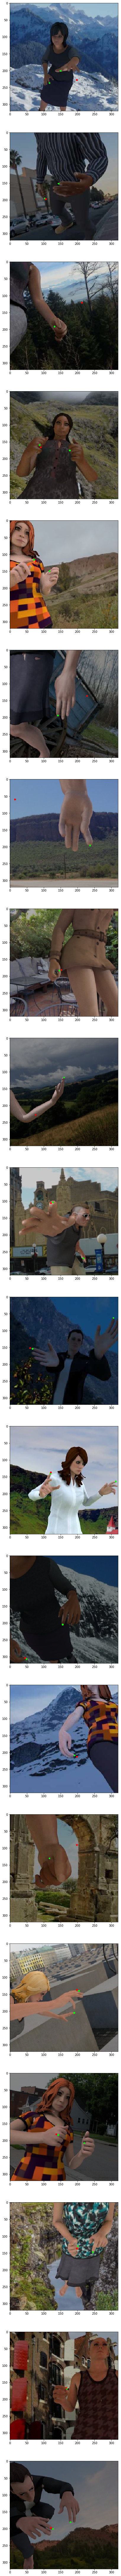

In [12]:
f, subs = plt.subplots(len(SAMPLES_TO_CHECK), 1, figsize=(15, 8*len(SAMPLES_TO_CHECK)))
for c, im in enumerate(images_show):
    subs[c].imshow(im)